In [45]:
import numpy as np
import scipy.io as sio
from scipy.integrate import solve_ivp
import scipy as sp
import matplotlib.pyplot as mpl
import pymc as pm
import arviz as az
import pandas as pd
import os
from datetime import datetime
import sys
from math import atan,cos,sin
from vd_class import vd_8dof
from point import Point

### Set up the vehilce model for the acceleration test

In [46]:
# A zero steering function
def zero_st(t):
    return 0 *t

def zero_throt(t):
    return 0 *t

def brake_tor(t):
    return 0 * t


# Used for obtaining the state from the chrono vehicle
n1  = 560
n2 = 1060


# The time duration of the simulation
st_time = 0.
end_time = 5.


# The times for which we want the simulation
t_eval  = np.arange(st_time,end_time,0.01)
time = np.arange(st_time,end_time,0.01)


state = pd.read_csv("rr_1.csv",sep=',',header='infer')

st = {'x' : state['x'][n1],'y':state['y'][n1],'u':state['vx'][n1],'v':state['vy'][n1],'psi':state['yaw'][n1],
'phi':state['roll'][n1],'wx':state['roll_rate'][n1],'wz':state['yaw_rate'][n1],
'wlf' : state['wlf'][n1],'wlr' : state['wlr'][n1],'wrf' : state['wrf'][n1],'wrr' : state['wrr'][n1]}

vehicle = vd_8dof(states = st)

# Set the steering and the throttle functions we just created above
vehicle.set_steering(zero_st)
vehicle.set_throttle(zero_throt,gr=0.3*0.2)
vehicle.set_braking(brake_tor)
vehicle.debug = 0


/home/huzaifa/research/tutorials/vd_class.py:1096: UserWarning: Set parameters to default values
{'a': 1.14, 'b': 1.4, 'Cf': 44000, 'Cr': 47000, 'Cxf': 5000, 'Cxr': 5000, 'm': 1400, 'Jz': 2420, 'r0': 0.285, 'Jw': 2, 'Jx': 900, 'Jy': 2000, 'Jxz': 90, 'h': 0.75, 'cf': 1.5, 'cr': 1.5, 'muf': 80, 'mur': 80, 'ktf': 200000, 'ktr': 200000, 'hrcf': 0.65, 'hrcr': 0.6, 'krof': 29000, 'kror': 29000, 'brof': 3000, 'bror': 3000, 'rr': 0.0125}
  warnings.warn("Set parameters to default values" +


### Get the data and chain files

In [47]:
# The chain file
filename = "20220612_025748"
idata = az.from_netcdf('./results/' + filename + ".nc")
dataFileName = "vd_chrono_rr_1.npy"
##The data in npy format
with open(dataFileName, 'rb') as f:
    data = np.load(f)
save = True

### Set up the posteriors and the priors on parameters of interest

In [48]:
shape = idata['posterior']['rr'].shape

posterior_rr = np.asarray(idata['posterior']['rr']).reshape(shape[0]*shape[1],)



prior_rr = np.random.uniform(low=0.005,high=0.03,size=(shape[0]*shape[1]),)



### Sample from the posterior

In [49]:
#Number of posterior lines
no_post = 100

#Random points to sample
random_points = np.random.randint(low=0,high=shape[0]*shape[1],size=(no_post,),dtype=int)

#The posterior data lines - Longitudinal Velocity, LF angular velocity and RF angular velocity
posterior_LOV = np.empty((no_post,time.shape[0]))
posterior_LFW = np.empty((no_post,time.shape[0]))
posterior_LRW = np.empty((no_post,time.shape[0]))


for i in range(0,no_post):
    vehicle.update_params(m=2097.85,muf=127.866,mur=129.98,a= 1.6889,b =1.6889,h = 0.713,cf = 1.82,cr = 1.82,
                          Jx = 1289,Jz = 4519,Jxz = 3.265,Cf=39000,Cr=48000,r0=0.47,ktf=326332,ktr=326332,
                          krof=31000.0,kror=31000.0,brof=3300.000,bror=3300.000,hrcf=0.379,hrcr=0.327,Jw=11,
                          Cxf =10950,Cxr =10791,rr=posterior_rr[random_points[i]])
    
    mod = vehicle.solve_half_impl(t_span = [t_eval[0],t_eval[-1]],t_eval = t_eval,tbar = 5e-3)
    mod = np.transpose(mod)
    vehicle.reset_state(init_state=st)
    posterior_LOV[i] = mod[2,:]
    posterior_LFW[i] = mod[8,:]
    posterior_LRW[i] = mod[9,:]

### Sample from the prior"

In [50]:
#Number of prior lines
no_post = 100

#Random points to sample
random_points = np.random.randint(low=0,high=shape[0]*shape[1],size=(no_post,),dtype=int)

#The prior data lines - Longitudinal Velocity, LF angular velocity and RF angular velocity
prior_LOV = np.empty((no_post,time.shape[0]))
prior_LFW = np.empty((no_post,time.shape[0]))
prior_LRW = np.empty((no_post,time.shape[0]))


for i in range(0,no_post):
    vehicle.update_params(m=2097.85,muf=127.866,mur=129.98,a= 1.6889,b =1.6889,h = 0.713,cf = 1.82,cr = 1.82,
                          Jx = 1289,Jz = 4519,Jxz = 3.265,Cf=39000,Cr=48000,r0=0.47,ktf=326332,ktr=326332,
                          krof=31000.0,kror=31000.0,brof=3300.000,bror=3300.000,hrcf=0.379,hrcr=0.327,Jw=11,
                          Cxf =10950,Cxr =10791,rr=prior_rr[random_points[i]])
    
    mod = vehicle.solve_half_impl(t_span = [t_eval[0],t_eval[-1]],t_eval = t_eval,tbar = 5e-3)
    mod = np.transpose(mod)
    vehicle.reset_state(init_state=st)
    prior_LOV[i] = mod[2,:]
    prior_LFW[i] = mod[8,:]
    prior_LRW[i] = mod[9,:]

### Posterior and prior expectation

In [51]:
#Posterior
post_exp_LOV = posterior_LOV.mean(axis=0)
post_exp_LFW = posterior_LFW.mean(axis=0)
post_exp_LRW = posterior_LRW.mean(axis=0)
#prior
prior_exp_LOV = prior_LOV.mean(axis=0)
prior_exp_LFW = prior_LFW.mean(axis=0)
prior_exp_LRW = prior_LRW.mean(axis=0)

### Plotting the mean posterior

In [52]:
## To plot the mean posterior 
post_rr = idata['posterior']['rr'].mean()

vehicle.update_params(m=2097.85,muf=127.866,mur=129.98,a= 1.6889,b =1.6889,h = 0.713,cf = 1.82,cr = 1.82,
                      Jx = 1289,Jz = 4519,Jxz = 3.265,Cf=39000,Cr=48000,r0=0.47,ktf=326332,ktr=326332,
                      krof=31000.0,kror=31000.0,brof=3300.000,bror=3300.000,hrcf=0.379,hrcr=0.327,Jw=11,
                      Cxf =10950,Cxr =10791,rr=post_rr)

mod = vehicle.solve_half_impl(t_span = [t_eval[0],t_eval[-1]],t_eval = t_eval,tbar = 5e-3)
mod = np.transpose(mod)
vehicle.reset_state(init_state=st)

post_mean_LOV = mod[2,:].reshape(-1,1)
post_mean_LFW = mod[8,:].reshape(-1,1)
post_mean_LRW = mod[9,:].reshape(-1,1)

### Plotting the mean prior

In [53]:
## To plot the mean priorerior 
prior_rr = prior_rr.mean()

vehicle.update_params(m=2097.85,muf=127.866,mur=129.98,a= 1.6889,b =1.6889,h = 0.713,cf = 1.82,cr = 1.82,
                      Jx = 1289,Jz = 4519,Jxz = 3.265,Cf=39000,Cr=48000,r0=0.47,ktf=326332,ktr=326332,
                      krof=31000.0,kror=31000.0,brof=3300.000,bror=3300.000,hrcf=0.379,hrcr=0.327,Jw=11,
                      Cxf =10950,Cxr =10791,rr=prior_rr)

mod = vehicle.solve_half_impl(t_span = [t_eval[0],t_eval[-1]],t_eval = t_eval,tbar = 5e-3)
mod = np.transpose(mod)
vehicle.reset_state(init_state=st)
prior_mean_LOV = mod[2,:].reshape(-1,1)
prior_mean_LFW = mod[8,:].reshape(-1,1)
prior_mean_LRW = mod[9,:].reshape(-1,1)

## Prior plots

### Longitudinal Velocity

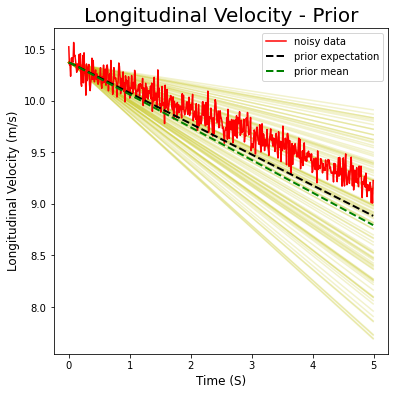

In [54]:
mpl.figure(figsize = (6,6))

for i in range(0,no_post):
    mpl.plot(time,prior_LOV[i,:],'y',alpha = 0.2)

# mpl.plot(time,data[])
mpl.plot(time,data[0,:],'r',label ='noisy data')
# mpl.plot(time,post_exp_LOV,'k',linewidth = 2,label='posterior expectiation')
mpl.plot(time,prior_exp_LOV,'k--',linewidth=2,label='prior expectation')
# mpl.plot(time,post_mean_LOV,'g',linewidth=2,label='posterior mean')
mpl.plot(time,prior_mean_LOV,'g--',linewidth=2,label='prior mean')
mpl.title("Longitudinal Velocity - Prior",fontsize = 20)
mpl.xlabel('Time (S)',fontsize = 12)
mpl.ylabel('Longitudinal Velocity (m/s)',fontsize = 12)
mpl.legend()
if(save):
    mpl.savefig('./images/LOV_rr_prior_1.png',facecolor = 'w')

### LF Angular velocity


IndexError: index 1 is out of bounds for axis 0 with size 1

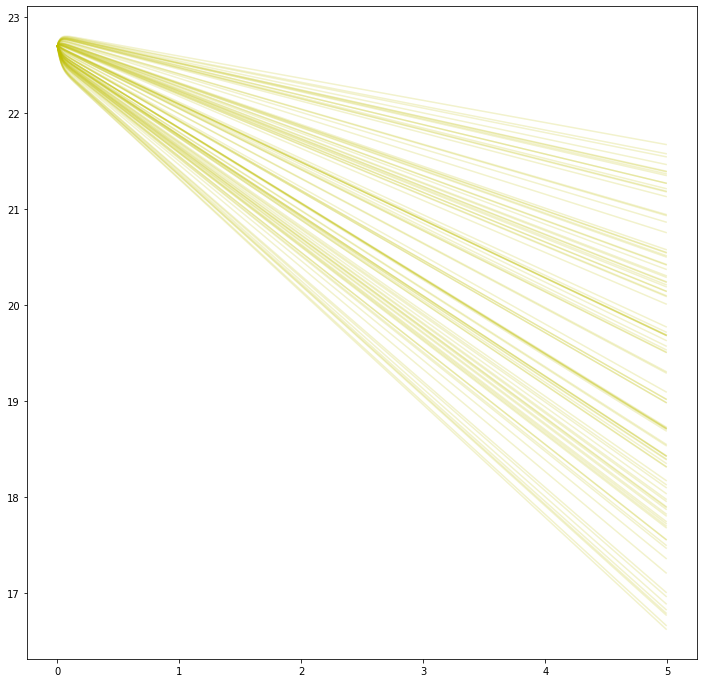

In [27]:
mpl.figure(figsize = (12,12))

for i in range(0,no_post):
    mpl.plot(time,prior_LFW[i,:],'y',alpha = 0.2)

# mpl.plot(time,data[])
mpl.plot(time,data[1,:],'r',label ='noisy data')
# mpl.plot(time,post_exp_LFW,'k',linewidth = 2,label='posterior expectiation')
mpl.plot(time,prior_exp_LFW,'k--',linewidth=2,label='prior expectation')
# mpl.plot(time,post_mean_LFW,'g',linewidth=2,label='posterior mean')
mpl.plot(time,prior_mean_LFW,'g--',linewidth=2,label='prior mean')
mpl.title("Angular Velocity (LF) - Prior",fontsize = 20)
mpl.xlabel('Time (S)',fontsize = 12)
mpl.ylabel('Angular Velocity (rps)',fontsize = 12)
mpl.legend()
if(save):
# mpl.savefig('./images/LFW_prior_rr_1.png',facecolor = 'w')

### LR Angular velocity

IndexError: index 2 is out of bounds for axis 0 with size 1

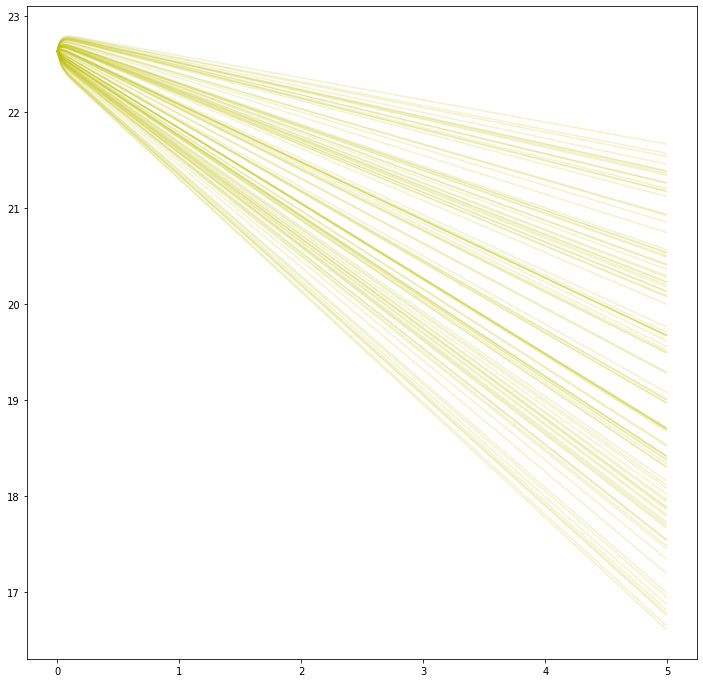

In [28]:
mpl.figure(figsize = (12,12))

for i in range(0,no_post):
    mpl.plot(time,prior_LRW[i,:],'y',alpha = 0.2)

# mpl.plot(time,data[])
mpl.plot(time,data[2,:],'r',label ='noisy data')
# mpl.plot(time,post_exp_LRW,'k',linewidth = 2,label='posterior expectiation')
mpl.plot(time,prior_exp_LRW,'k--',linewidth=2,label='prior expectation')
# mpl.plot(time,post_mean_LRW,'g',linewidth=2,label='posterior mean')
mpl.plot(time,prior_mean_LRW,'g--',linewidth=2,label='prior mean')
mpl.title("Angular Velocity (LR) - Prior",fontsize = 20)
mpl.xlabel('Time (S)',fontsize = 12)
mpl.ylabel('Angular Velocity (rps)',fontsize = 12)
mpl.legend()
# mpl.savefig('./images/LRW_prior_rr_1.png',facecolor = 'w')

## Posterior plots

### Longitudinal Velocity

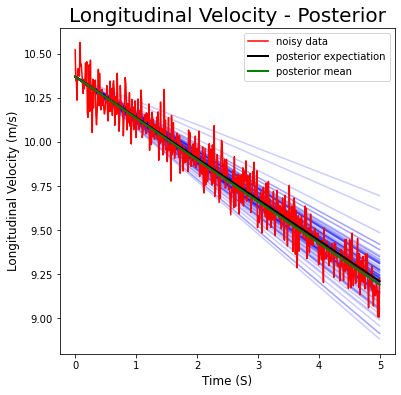

In [55]:
mpl.figure(figsize = (6,6))

for i in range(0,no_post):
    mpl.plot(time,posterior_LOV[i,:],'b',alpha=0.2)

# mpl.plot(time,data[])
mpl.plot(time,data[0,:],'r',label ='noisy data')
mpl.plot(time,post_exp_LOV,'k',linewidth = 2,label='posterior expectiation')
# mpl.plot(time,prior_exp_LOV,'k--',linewidth=2,label='prior expectation')
mpl.plot(time,post_mean_LOV,'g',linewidth=2,label='posterior mean')
# mpl.plot(time,prior_mean_LOV,'g--',linewidth=2,label='prior mean')
mpl.title("Longitudinal Velocity - Posterior",fontsize = 20)
mpl.xlabel('Time (S)',fontsize = 12)
mpl.ylabel('Longitudinal Velocity (m/s)',fontsize = 12)
mpl.legend()
if(save):
    mpl.savefig('./images/LOV_rr_post_1.png',facecolor = 'w')

### Angular velocity (LF)

IndexError: index 1 is out of bounds for axis 0 with size 1

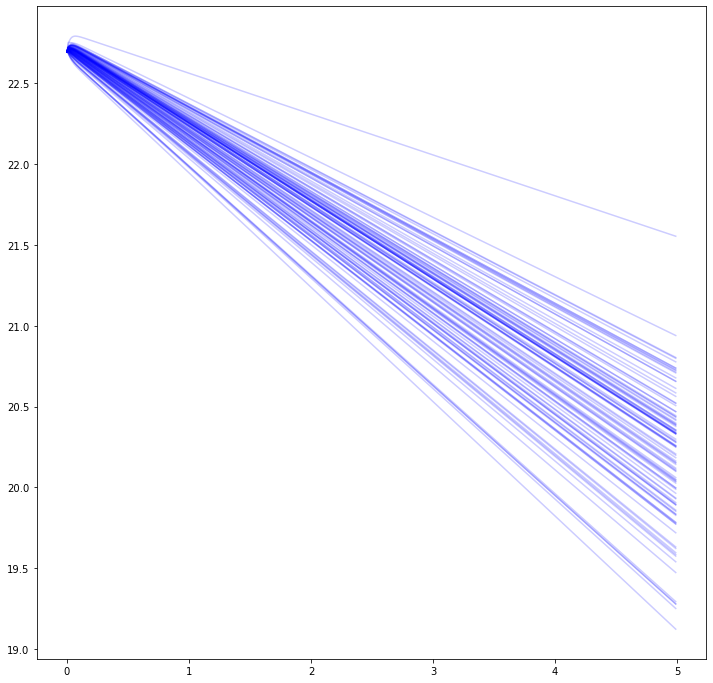

In [30]:
mpl.figure(figsize = (12,12))

for i in range(0,no_post):
    mpl.plot(time,posterior_LFW[i,:],'b',alpha=0.2)

# mpl.plot(time,data[])
mpl.plot(time,data[1,:],'r',label ='noisy data')
mpl.plot(time,post_exp_LFW,'k',linewidth = 2,label='posterior expectiation')
# mpl.plot(time,prior_exp_LFW,'k--',linewidth=2,label='prior expectation')
mpl.plot(time,post_mean_LFW,'g',linewidth=2,label='posterior mean')
# mpl.plot(time,prior_mean_LFW,'g--',linewidth=2,label='prior mean')
mpl.title("Angular Velocity (LF) - Posterior",fontsize = 20)
mpl.xlabel('Time (S)',fontsize = 12)
mpl.ylabel('Angular Velocity (rps)',fontsize = 12)
mpl.legend()
# mpl.savefig('./images/LFW_post_rr_1.png',facecolor = 'w')

### Angular velocity (LR)

IndexError: index 2 is out of bounds for axis 0 with size 1

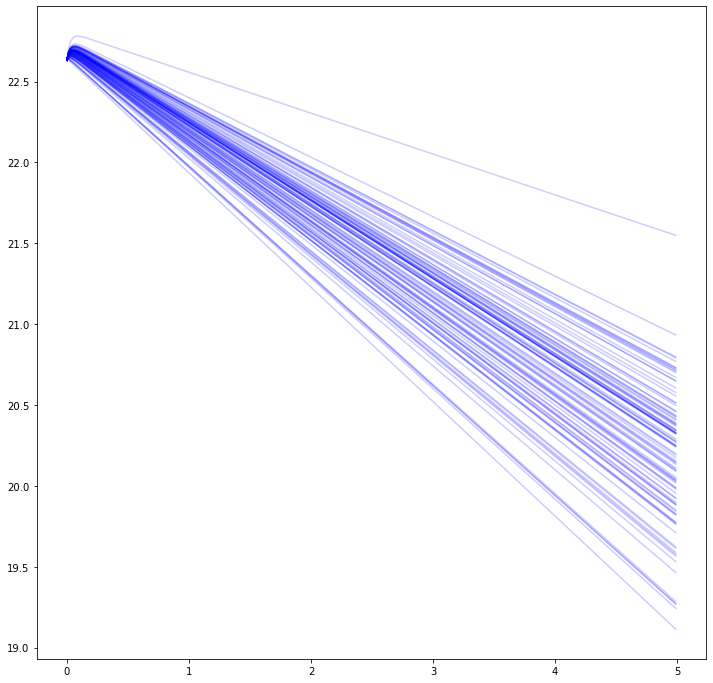

In [31]:
mpl.figure(figsize = (12,12))

for i in range(0,no_post):
    mpl.plot(time,posterior_LRW[i,:],'b',alpha=0.2)

# mpl.plot(time,data[])
mpl.plot(time,data[2,:],'r',label ='noisy data')
mpl.plot(time,post_exp_LRW,'k',linewidth = 2,label='posterior expectiation')
# mpl.plot(time,prior_exp_LRW,'k--',linewidth=2,label='prior expectation')
mpl.plot(time,post_mean_LRW,'g',linewidth=2,label='posterior mean')
# mpl.plot(time,prior_mean_LRW,'g--',linewidth=2,label='prior mean')
mpl.title("Angular Velocity (LR) - Posterior",fontsize = 20)
mpl.xlabel('Time (S)',fontsize = 12)
mpl.ylabel('Angular Velocity (rps)',fontsize = 12)
mpl.legend()
# mpl.savefig('./images/LRW_post_rr_1.png',facecolor = 'w')

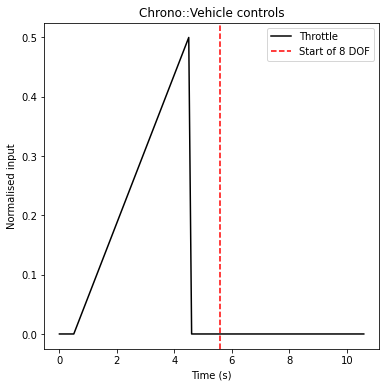

In [5]:
def zero_st(t):
    return 0 *t

def zero_throt(t):
    return 0 *t

tpt1 = Point(0.5,0)
tpt2 = Point(4.5,0.5)
tpt3 = Point(4.6,0)
tpt4 = Point(10.6,0)

th_1 = tpt1.get_eq(tpt2)
th_2 = tpt2.get_eq(tpt3)
th_3 = tpt3.get_eq(tpt4)


def throt(t):
    if(t<0.5):
        return 0
    elif(t < 4.5):
        return th_1(t)
    elif(t < 4.6):
        return th_2(t)
    else:
        return th_3(t)

    
# The time duration of the simulation
st_time = 0.
end_time = 10.6


# The times for which we want the simulation
time  = np.arange(st_time,end_time,0.01)
t_eval = np.arange(st_time,end_time,0.01)

th = []
s = []
for t in t_eval:
    th.append(throt(t))
    
mpl.figure(figsize = (6,6))
mpl.plot(t_eval,th,'k')
mpl.axvline(x=5.6,color='r',ls='--',label='Start of 8 DOF')
mpl.legend(['Throttle','Start of 8 DOF'])
mpl.xlabel('Time (s)')
mpl.ylabel('Normalised input')
mpl.title('Chrono::Vehicle controls')
mpl.savefig('./images/rr_input.png',facecolor = 'w')
mpl.show()

In [56]:
rmse_post_LOV = np.mean(np.sqrt((np.sum((posterior_LOV - data[0,:])**2,axis=1)/data.shape[1])))

In [57]:
rmse_post_LOV

0.10976862187861723

In [58]:
msae_prior_LOV = np.mean(np.sqrt((np.sum((prior_LOV - data[0,:])**2,axis=1)/data.shape[1])))

In [59]:
msae_prior_LOV

0.33250539820115455